##### 导入对应库

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectPercentile, chi2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

##### 确保设备（GPU或CPU）正确设置

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 数据预处理与增强

##### 调整图像大小：确保所有输入图像的尺寸一致，以适应神经网络的输入要求。这里将图像大小调整为32x32像素。
##### 随机水平翻转：增强数据集的多样性，通过随机水平翻转图像，模型可以学习到更多的特征，减少过拟合。
##### 随机旋转：随机旋转图像一定角度，进一步增加数据多样性。
##### 颜色抖动：调整图像的亮度、对比度、饱和度和色调，模拟不同的拍摄条件，使模型更具有鲁棒性。
##### 标准化：对图像进行标准化处理，使其符合预训练模型的要求，通常使用ImageNet数据集的均值和标准差进行标准化。

In [3]:
# 数据预处理和增强
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 使用torchvision.datasets.ImageFolder加载数据集
##### 它假定数据集按照子文件夹进行组织，每个子文件夹名对应一个类别标签。这里分别加载了训练数据集和测试数据集，并应用了上述的预处理和增强操作。通过DataLoader实现批量数据加载，提高了数据加载效率。

In [4]:
# 加载数据集
train_dataset = torchvision.datasets.ImageFolder(root='melanoma_cancer_dataset/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = torchvision.datasets.ImageFolder(root='melanoma_cancer_dataset/test', transform=transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

##### 定义模型

In [5]:
# 定义卷积尖峰神经网络模型
class SpikingCNN(nn.Module):
    def __init__(self):
        super(SpikingCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=2)  # 使用 padding 确保尺寸不减小过多
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 4 * 4, 120)  # 调整全连接层输入大小
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = self.pool(F.relu(self.conv3(x)))  # 8x8 -> 4x4
        x = x.view(-1, 32 * 4 * 4)  # 展平处理
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# 初始化模型
model = SpikingCNN().to(device)

##### 定义损失函数和优化器

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##### 早停机制的参数

In [7]:
early_stopping_patience = 10
early_stopping_counter = 0
best_val_loss = float('inf')


### 训练和验证

In [8]:
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []
train_recall_scores = []
val_recall_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    train_preds = []
    train_labels = []
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    train_f1_scores.append(f1_score(train_labels, train_preds))
    train_recall_scores.append(recall_score(train_labels, train_preds))

    # 验证模式
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100 * correct / total)
    val_f1_scores.append(f1_score(val_labels, val_preds))
    val_recall_scores.append(recall_score(val_labels, val_preds))
    
    # 早停机制
    if val_loss / len(test_loader) < best_val_loss:
        best_val_loss = val_loss / len(test_loader)
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # 打印当前轮次的损失和准确率
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%, Train F1: {train_f1_scores[-1]:.2f}, Val F1: {val_f1_scores[-1]:.2f}, Train Recall: {train_recall_scores[-1]:.2f}, Val Recall: {val_recall_scores[-1]:.2f}")

Epoch 1/20 - Training:   0%|                                                                   | 0/301 [00:00<?, ?it/s]C:\Users\Administrator\anaconda3\envs\jiqi\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\Administrator\anaconda3\envs\jiqi\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/20 - V

Epoch 1/20, Train Loss: 0.4596, Val Loss: 0.3384, Train Acc: 77.69%, Val Acc: 85.90%, Train F1: 0.76, Val F1: 0.84, Train Recall: 0.75, Val Recall: 0.75


Epoch 2/20 - Validation: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.52it/s]


Epoch 2/20, Train Loss: 0.3684, Val Loss: 0.2929, Train Acc: 83.86%, Val Acc: 88.10%, Train F1: 0.83, Val F1: 0.87, Train Recall: 0.81, Val Recall: 0.82


Epoch 3/20 - Validation: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.48it/s]


Epoch 3/20, Train Loss: 0.3442, Val Loss: 0.3104, Train Acc: 85.40%, Val Acc: 88.80%, Train F1: 0.84, Val F1: 0.88, Train Recall: 0.81, Val Recall: 0.80


Epoch 4/20 - Validation: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.58it/s]


Epoch 4/20, Train Loss: 0.3213, Val Loss: 0.2597, Train Acc: 85.64%, Val Acc: 90.10%, Train F1: 0.85, Val F1: 0.90, Train Recall: 0.82, Val Recall: 0.86


Epoch 5/20 - Validation: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.55it/s]


Epoch 5/20, Train Loss: 0.3080, Val Loss: 0.2638, Train Acc: 86.54%, Val Acc: 89.80%, Train F1: 0.86, Val F1: 0.89, Train Recall: 0.83, Val Recall: 0.87


Epoch 6/20 - Validation: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.46it/s]


Epoch 6/20, Train Loss: 0.3038, Val Loss: 0.2669, Train Acc: 87.03%, Val Acc: 90.60%, Train F1: 0.86, Val F1: 0.90, Train Recall: 0.84, Val Recall: 0.87


Epoch 7/20 - Validation: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.47it/s]


Epoch 7/20, Train Loss: 0.2965, Val Loss: 0.2584, Train Acc: 87.32%, Val Acc: 90.40%, Train F1: 0.86, Val F1: 0.90, Train Recall: 0.84, Val Recall: 0.86


Epoch 8/20 - Validation: 100%|█████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 8/20, Train Loss: 0.2883, Val Loss: 0.2513, Train Acc: 87.26%, Val Acc: 90.10%, Train F1: 0.86, Val F1: 0.90, Train Recall: 0.84, Val Recall: 0.86


Epoch 9/20 - Validation: 100%|█████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.38it/s]


Epoch 9/20, Train Loss: 0.2890, Val Loss: 0.2693, Train Acc: 87.71%, Val Acc: 90.20%, Train F1: 0.87, Val F1: 0.90, Train Recall: 0.85, Val Recall: 0.88


Epoch 10/20 - Validation: 100%|████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.45it/s]


Epoch 10/20, Train Loss: 0.2824, Val Loss: 0.2680, Train Acc: 88.02%, Val Acc: 90.20%, Train F1: 0.87, Val F1: 0.90, Train Recall: 0.85, Val Recall: 0.87


Epoch 11/20 - Validation: 100%|████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.45it/s]


Epoch 11/20, Train Loss: 0.2772, Val Loss: 0.2709, Train Acc: 88.27%, Val Acc: 90.50%, Train F1: 0.87, Val F1: 0.90, Train Recall: 0.84, Val Recall: 0.89


Epoch 12/20 - Validation: 100%|████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.47it/s]


Epoch 12/20, Train Loss: 0.2699, Val Loss: 0.2583, Train Acc: 88.61%, Val Acc: 91.00%, Train F1: 0.88, Val F1: 0.91, Train Recall: 0.85, Val Recall: 0.87


Epoch 13/20 - Validation: 100%|████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.37it/s]


Epoch 13/20, Train Loss: 0.2719, Val Loss: 0.2868, Train Acc: 88.54%, Val Acc: 90.40%, Train F1: 0.88, Val F1: 0.90, Train Recall: 0.86, Val Recall: 0.86


Epoch 14/20 - Validation: 100%|████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.33it/s]


Epoch 14/20, Train Loss: 0.2642, Val Loss: 0.2566, Train Acc: 88.67%, Val Acc: 89.60%, Train F1: 0.88, Val F1: 0.90, Train Recall: 0.86, Val Recall: 0.90


Epoch 15/20 - Validation: 100%|████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.35it/s]


Epoch 15/20, Train Loss: 0.2695, Val Loss: 0.2495, Train Acc: 88.43%, Val Acc: 91.40%, Train F1: 0.88, Val F1: 0.91, Train Recall: 0.86, Val Recall: 0.88


Epoch 16/20 - Validation: 100%|████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.39it/s]


Epoch 16/20, Train Loss: 0.2685, Val Loss: 0.2477, Train Acc: 88.39%, Val Acc: 90.50%, Train F1: 0.88, Val F1: 0.90, Train Recall: 0.85, Val Recall: 0.85


Epoch 17/20 - Validation: 100%|████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.47it/s]


Epoch 17/20, Train Loss: 0.2629, Val Loss: 0.2390, Train Acc: 88.68%, Val Acc: 90.80%, Train F1: 0.88, Val F1: 0.90, Train Recall: 0.86, Val Recall: 0.87


Epoch 18/20 - Validation: 100%|████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.43it/s]


Epoch 18/20, Train Loss: 0.2644, Val Loss: 0.2486, Train Acc: 88.69%, Val Acc: 89.80%, Train F1: 0.88, Val F1: 0.89, Train Recall: 0.86, Val Recall: 0.86


Epoch 19/20 - Validation: 100%|████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.49it/s]


Epoch 19/20, Train Loss: 0.2548, Val Loss: 0.2429, Train Acc: 89.43%, Val Acc: 91.10%, Train F1: 0.89, Val F1: 0.91, Train Recall: 0.87, Val Recall: 0.90


Epoch 20/20 - Validation: 100%|████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.32it/s]

Epoch 20/20, Train Loss: 0.2550, Val Loss: 0.2576, Train Acc: 89.17%, Val Acc: 90.90%, Train F1: 0.88, Val F1: 0.91, Train Recall: 0.87, Val Recall: 0.89


### 绘制图

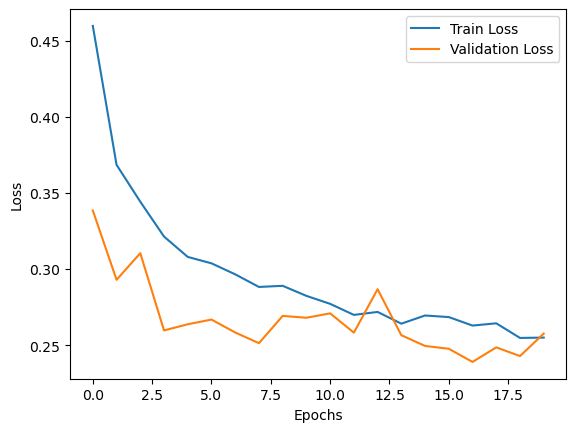

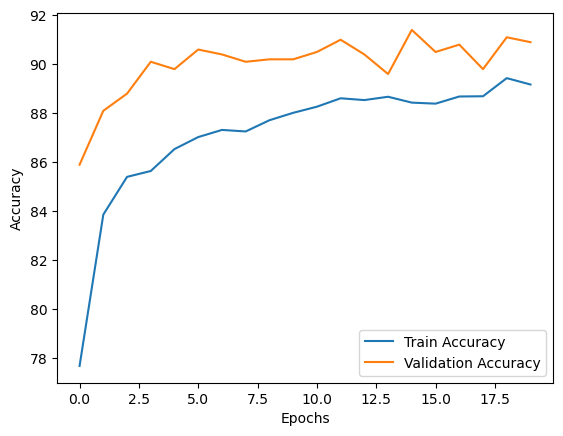

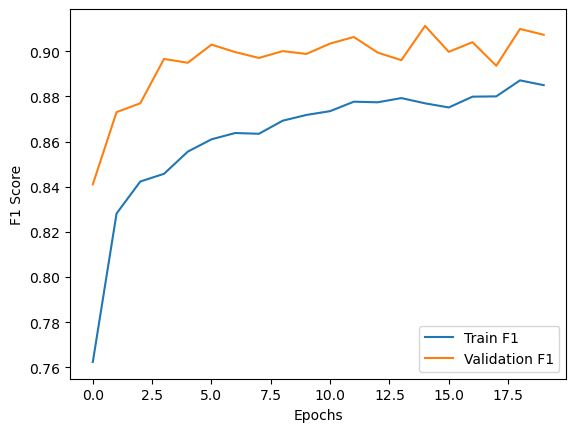

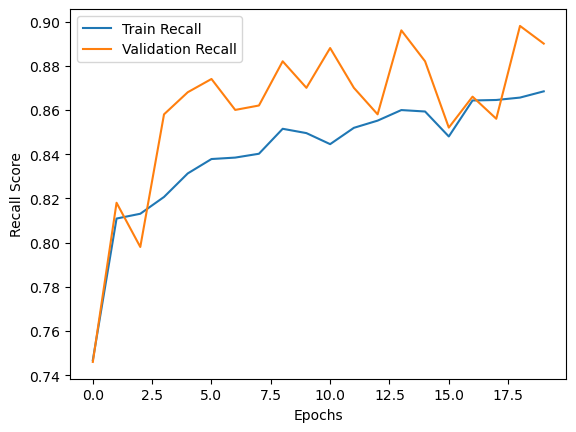

In [9]:
# 绘制训练和验证的损失曲线
plt.figure()
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练和验证的准确率曲线
plt.figure()
plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制F1得分曲线
plt.figure()
plt.plot(range(len(train_f1_scores)), train_f1_scores, label='Train F1')
plt.plot(range(len(val_f1_scores)), val_f1_scores, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 绘制召回率曲线
plt.figure()
plt.plot(range(len(train_recall_scores)), train_recall_scores, label='Train Recall')
plt.plot(range(len(val_recall_scores)), val_recall_scores, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall Score')
plt.legend()
plt.show()

#### 提取特征和标签

In [10]:

def extract_features_and_labels(loader):
    features = []
    labels = []
    for inputs, lbls in loader:
        inputs = inputs.to(device)
        outputs = model.pool(F.relu(model.conv3(model.pool(F.relu(model.conv2(model.pool(F.relu(model.conv1(inputs)))))))))
        outputs = outputs.view(outputs.size(0), -1).cpu().detach().numpy()
        features.append(outputs)
        labels.append(lbls.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

train_features, train_labels = extract_features_and_labels(train_loader)
test_features, test_labels = extract_features_and_labels(test_loader)


#### 特征选择（使用卡方检验）

In [11]:
selector = SelectPercentile(chi2, percentile=10)
train_features_selected = selector.fit_transform(train_features, train_labels)
test_features_selected = selector.transform(test_features)

# 训练SVM分类器

In [12]:
svm_classifier = SVC(kernel='linear', C=2)
svm_classifier.fit(train_features_selected, train_labels)

SVC(C=2, kernel='linear')

### 测试集上的预测和评估
### 计算评估指标

In [13]:
test_predictions = svm_classifier.predict(test_features_selected)
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9030
Precision: 0.9390
Recall: 0.8620
F1 Score: 0.8989
